# Simulating and Analyzing Genetic Relatedness in DZ Twins
This notebook focuses on simulating genetic relatedness in dizygotic (DZ) twins and analyzing the results. We explore how genetic factors contribute to relatedness using different encoding models and visualize the outcomes.

## Import Required Libraries
We begin by importing the necessary libraries:
- `os`: For file path operations.
- `numpy`: For numerical computations.
- `pandas`: For data manipulation and analysis.
- `matplotlib.pyplot` and `seaborn`: For data visualization.
- `tqdm`: For progress tracking during simulations.

In [18]:
# Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Define Genotype Generation Functions
The `make_dz_genotype_for_sinlge_locus` function simulates the genetic makeup of DZ twins at a single locus. It generates parental haplotypes and samples gametes to create offspring genotypes.

In [19]:
# Genotype generation functions
def make_dz_genotype_for_sinlge_locus(n_pairs: int, f: float, seed: int):
    rng = np.random.default_rng(seed)

    # Parental haplotypes
    father = rng.binomial(1, f, size=(n_pairs, 2))
    mother = rng.binomial(1, f, size=(n_pairs, 2))
    
    # Gamete sampling
    g1 = father[np.arange(n_pairs), rng.integers(0, 2, size=n_pairs)] + \
         mother[np.arange(n_pairs), rng.integers(0, 2, size=n_pairs)]
    g2 = father[np.arange(n_pairs), rng.integers(0, 2, size=n_pairs)] + \
         mother[np.arange(n_pairs), rng.integers(0, 2, size=n_pairs)]
    
    return g1, g2

## Encode Genotypes
We use two encoding methods:
1. **Additive-Dominance (AD)**: Encodes additive and dominance effects.
2. **Factor Model**: Encodes heterozygous and homozygous effects.

The `encode_genotype` function selects the appropriate encoding method.

In [20]:
# Encoding functions
def encoding_AD(g: np.ndarray, f: float):
     # Standardize
     g_dom_gramschmidt = np.where(g == 0, 0, np.where(g == 1, 2*f, 4*f - 2))
     X = np.stack([g, g_dom_gramschmidt], axis=1).astype(float)
     X_std = X.copy()
     X_std[:, 0] = (X[:, 0] - 2*f) / np.sqrt(2*f*(1-f))
     X_std[:, 1] = (X[:, 1] - (2*(f**2))) / (2*f*(1-f))
     return X, X_std

def encoding_Factor(g: np.ndarray, f: float):
     U = np.stack([g == 1, g == 2], axis=1).astype(float)
     
     # Standardize
     p1, p2 = 2*f*(1-f), f**2
     mu = np.array([p1, p2])
     a = p1*(1-p1)
     b = -p1*p2
     c = p2*(1-p2)
     det = a*c - b**2

     W = np.array([[1/np.sqrt(a), 0],
                    [p1*p2/np.sqrt(a*det), np.sqrt(a/det)]])

     U_std = (U - mu) @ W.T

     return U, U_std

def encode_genotype(g: np.ndarray, f: float, method: str):
     if method == "AD":
          return encoding_AD(g, f)
     elif method == "Factor":
          return encoding_Factor(g, f)
     else:
          raise NotImplementedError(f"Method {method} is not implemented")

## Check Genotype and Standardization
We now use the encoding functions to standardize genotypes and calculate their mean and variance. This helps verify the correctness of the encoding process.

In [21]:
# Check genotype and standardization
n_pairs = 1_000_000
maf = 0.2
seed = 123
g1, g2 = make_dz_genotype_for_sinlge_locus(n_pairs, maf, seed)

# AD model
g_raw, g_std = encode_genotype(g1, maf, method="AD")
print(f"""
Mean and variance of AD model:
Mean : {np.mean(g_std, axis=0).round(2)}
Variance : {np.var(g_std, axis=0).round(2)}
""")

# Factor model
g_raw, g_std = encode_genotype(g1, maf, method="Factor")
print(f"""
Mean and variance of Factor model:
Mean : {np.mean(g_std, axis=0).round(2)}
Variance : {np.var(g_std, axis=0).round(2)}
""")


Mean and variance of AD model:
Mean : [-0.  0.]
Variance : [1. 1.]


Mean and variance of Factor model:
Mean : [-0. -0.]
Variance : [1.   0.99]



## Calculate Covariance for DZ Twins
The `dz_cov` function calculates covariance matrices for the `AD` and `Factor` models, which represent genetic relatedness between DZ twins.

In [22]:
def dz_cov(n_pairs: int, maf: float, seed: int):
    g1, g2 = make_dz_genotype_for_sinlge_locus(n_pairs, maf, seed)
    
    # Additive model
    _, X1_std = encode_genotype(g1, maf, method="AD")
    _, X2_std = encode_genotype(g2, maf, method="AD")
    cov_AD = X1_std.T @ X2_std / n_pairs
    
    # Factor model
    _, X1_std = encode_genotype(g1, maf, method="Factor")
    _, X2_std = encode_genotype(g2, maf, method="Factor")
    cov_Factor = X1_std.T @ X2_std / n_pairs
    
    return cov_AD, cov_Factor

## Iterative Simulation for Genetic Relatedness
We simulate genetic relatedness across different minor allele frequencies (MAF) and store the results in a DataFrame for further analysis.

In [23]:
# Iterative simulation
n_pairs = 100_000
df = pd.DataFrame(columns=["MAF", "Model", "gamma_11", "gamma_22", "gamma_12"])

for f in tqdm(np.linspace(0.01, 0.5, 100)):
    for _ in range(100):
        gamma_AD, gamma_Factor = dz_cov(n_pairs, f, np.random.randint(0, 10000))
        df = pd.concat([df, pd.DataFrame({
            "MAF": f,
            "Model": ["AD", "Factor"],
            "gamma_11": [gamma_AD[0, 0], gamma_Factor[0, 0]],
            "gamma_22": [gamma_AD[1, 1], gamma_Factor[1, 1]],
            "gamma_12": [gamma_AD[0, 1], gamma_Factor[0, 1]]
        })])

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/2b/0852f9994h3dls0xx_wwhjxc0000gn/T/ipykernel_4519/2945284437.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({
100%|██████████| 100/100 [02:11<00:00,  1.31s/it]


## Visualize Results
We use Seaborn to visualize the genetic relatedness results. The plots highlight differences between the `AD` and `Factor` models.

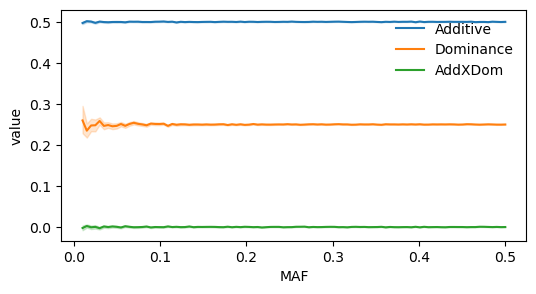

In [24]:
# AD model visualization
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.lineplot(
    data=df[df["Model"] == "AD"].melt(id_vars=["MAF", "Model"]),
    x="MAF",
    y="value",
    hue="variable",
    estimator='mean',
    errorbar=('ci', 95),
    ax=ax
)
handles, labels = ax.get_legend_handles_labels()
labels = ["Additive", "Dominance", "AddXDom"]
ax.legend(handles=handles, labels=labels, title=None, frameon=False)

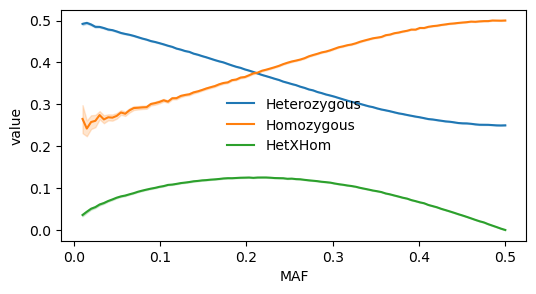

In [25]:
# Factor model visualization
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.lineplot(
    data=df[df["Model"] == "Factor"].melt(id_vars=["MAF", "Model"]),
    x="MAF",
    y="value",
    hue="variable",
    estimator='mean',
    errorbar=('ci', 95),
    ax=ax
)
handles, labels = ax.get_legend_handles_labels()
labels = ["Heterozygous", "Homozygous", "HetXHom"]
ax.legend(handles=handles, labels=labels, title=None, frameon=False)

## Interpret Results
The visualizations reveal key differences between the `AD` and `Factor` models:

1. **Additive-Dominance Model**:
   - The additive effect shows a consistent trend (0.5) across MAF values.
   - Dominance effects are less pronounced but still contribute (0.25) to genetic relatedness.
   - Interaction effects (AddXDom) are minimal (0), indicating limited interplay between additive and dominance components.

2. **Factor Model**:
   - Heterozygous effects dominate at lower MAF values, reflecting the higher likelihood of heterozygous genotypes in rare alleles.
   - Homozygous effects increase with MAF, as the probability of homozygous genotypes rises.
   - Interaction effects (HetXHom) are subtle but provide additional insights into genotype interactions.

These results highlight the distinct ways in which the two models capture genetic relatedness, with the `Factor` model providing a more nuanced view of heterozygous and homozygous contributions.